# 🎯 Objetivo do Projeto: Segmentação de Clientes em E-Commerce

## Contexto
Este projeto utiliza o conjunto de dados **"E-Commerce Data" (UCI Machine Learning Repository)**, que contém transações históricas de uma loja de varejo online baseada no Reino Unido. O objetivo principal é aplicar técnicas de **Aprendizado de Máquina Não Supervisionado** (Unsupervised Learning) para identificar padrões de comportamento de consumo.

## O Desafio de Negócio
Em um cenário de e-commerce, tratar todos os clientes da mesma forma é ineficiente. O objetivo desta análise é segmentar a base de clientes em grupos distintos (clusters) para permitir estratégias de marketing personalizadas, tais como:
* Identificar clientes **VIPs** (alto valor e alta frequência).
* Detectar clientes em risco de **Churn** (inativos recentemente).
* Reativar clientes com compras esporádicas.

## Abordagem Técnica
Para realizar o agrupamento, utilizaremos o algoritmo **K-Means**. No entanto, como o dataset original é *transacional* (cada linha é um item comprado), será necessário realizar um processo robusto de **Engenharia de Dados** para transformar esses registros em uma visão centrada no cliente (Customer-Centric).

A metodologia aplicada será a análise **RFM**, criando as seguintes <i>features</i> para o modelo:
1.  **Recência (Recency):** Há quantos dias foi a última compra do cliente?
2.  **Frequência (Frequency):** Quantas compras o cliente realizou no período?
3.  **Monetarização (Monetary):** Qual o valor total gasto pelo cliente?

---

In [1]:
import os

# Define o nome do dataset
dataset_slug = "carrie1/ecommerce-data"
arquivo_esperado = "data.csv"

# Verifica se o arquivo já existe para não baixar repetidamente
if not os.path.exists(arquivo_esperado):
    print("Arquivo não encontrado. Baixando do Kaggle...")
    # O comando '!' executa comandos do terminal dentro do notebook
    !kaggle datasets download -d {dataset_slug} --unzip
    print("Download concluído!")
else:
    print("O dataset já está na pasta.")

Arquivo não encontrado. Baixando do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown

Download concluído!



  0%|          | 0.00/7.20M [00:00<?, ?B/s]
 14%|█▍        | 1.00M/7.20M [00:00<00:03, 2.05MB/s]
 28%|██▊       | 2.00M/7.20M [00:00<00:01, 3.74MB/s]
 56%|█████▌    | 4.00M/7.20M [00:00<00:00, 7.41MB/s]
 97%|█████████▋| 7.00M/7.20M [00:00<00:00, 13.1MB/s]
100%|██████████| 7.20M/7.20M [00:00<00:00, 8.82MB/s]


In [3]:
# 1. Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Carregando os dados (apontando para o arquivo que o script baixou)
# O encoding é necessário pois a base contém caracteres especiais de moedas europeias
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

# Visualizando as primeiras linhas
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# 3. Verificação da estrutura
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [5]:
# Verificando a distribuição numérica
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# 2. Tratamento e Limpeza de Dados (Data Cleaning)

A análise exploratória inicial revelou inconsistências na estrutura dos dados que impactam diretamente a construção da matriz RFM (Recência, Frequência e Monetarização). Para garantir a integridade da clusterização pelo algoritmo K-Means, foram aplicadas as seguintes regras de negócio no pré-processamento:

1.  **Remoção de Identificadores Nulos:** Registros sem `CustomerID` não permitem o rastreamento do comportamento do consumidor. Como o objetivo é a segmentação de clientes, transações anônimas foram descartadas.
2.  **Filtragem de Quantidades Negativas:** A coluna `Quantity` apresentava valores negativos, indicativos de cancelamentos ou devoluções (frequentemente associados ao código de fatura iniciado com 'C'). Para analisar o potencial de compra, o dataset foi filtrado para conter apenas transações efetivadas (quantidade > 0).
3.  **Correção de Preços Unitários:** Foram identificados registros com `UnitPrice` igual ou inferior a zero, sugerindo erros de sistema, testes ou concessão de brindes. Tais registros foram removidos para evitar distorções no cálculo do valor monetário total.

In [6]:
# Verificando o tamanho do dataset antes da limpeza
print(f"Dimensões Originais: {df.shape}")

# 1. Tratamento de Nulos: Remover linhas onde CustomerID é NA
# Criando um novo dataframe 'df_clean' para preservar o original se necessário
df_clean = df.dropna(subset=['CustomerID'])

# 2. Tratamento de Negativos e Zeros:
# Manter apenas transações com Quantidade > 0 e Preço > 0
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Verificando o tamanho do dataset após a limpeza
print(f"Dimensões Após Limpeza: {df_clean.shape}")

# Validando a limpeza através das estatísticas descritivas
# Os valores mínimos (min) de Quantity e UnitPrice agora devem ser positivos
display(df_clean[['Quantity', 'UnitPrice']].describe())

Dimensões Originais: (541909, 8)
Dimensões Após Limpeza: (397884, 8)


,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


# 3. Engenharia de Atributos (Feature Engineering)

Para viabilizar a segmentação comportamental, o dataset transacional foi transformado em uma estrutura centrada no cliente (Customer-Level Data). Foi adotada a metodologia **RFM (Recency, Frequency, Monetary)**, padrão de mercado para análise de valor do cliente.

As seguintes transformações foram realizadas:
1.  **Cálculo de Receita Total:** Criação da variável `TotalAmount` (`Quantity` * `UnitPrice`) para mensurar o valor monetário de cada transação.
2.  **Conversão Temporal:** A variável `InvoiceDate` foi convertida para o formato `datetime` para permitir cálculos de intervalo de tempo.
3.  **Definição do Snapshot:** Foi estabelecida uma data de referência (um dia após a última transação registrada no dataset) para calcular a recência de forma consistente.
4.  **Agregação por Cliente:** O dataset foi agrupado por `CustomerID`, calculando-se:
    * **Recency:** Dias decorridos desde a última compra até a data de referência.
    * **Frequency:** Contagem distinta de faturas (`InvoiceNo`) por cliente.
    * **Monetary:** Somatório do `TotalAmount` gasto pelo cliente.

In [7]:
# 1. Criar a coluna de valor total da transação
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 2. Converter a data de string para datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 3. Definir a data de referência (Snapshot Date)
# Usamos o dia seguinte à última data do dataset para simular que estamos analisando no "dia seguinte"
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

print(f"Data de Referência para Recência: {snapshot_date}")

# 4. Agregação RFM 
# Agrupamos por ID e aplicamos funções diferentes para cada coluna
df_rfm = df_clean.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recência: Data Ref - Última Compra
    'InvoiceNo': 'nunique',                                  # Frequência: Contagem única de notas fiscais
    'TotalAmount': 'sum'                                     # Monetário: Soma dos gastos
})

# Renomear as colunas para facilitar a leitura
df_rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

# Visualizar a nova "cara" do dataset (agora temos 1 linha por cliente!)
display(df_rfm.head())
print(f"Dimensões da Tabela RFM: {df_rfm.shape}")

Data de Referência para Recência: 2011-12-10 12:50:00


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Dimensões da Tabela RFM: (4338, 3)


# 4. Padronização de Dados (Feature Scaling)

O algoritmo K-Means calcula a similaridade entre os pontos baseando-se na **Distância Euclidiana**. Como as variáveis da matriz RFM possuem escalas de grandeza distintas (e.g., *Monetary* pode chegar a milhares, enquanto *Frequency* geralmente permanece em dezenas), o algoritmo seria enviesado a priorizar a variável com maior magnitude numérica.

Para neutralizar esse efeito e garantir que todas as variáveis tenham o mesmo peso na formação dos clusters, foi aplicado o método **StandardScaler**.
* **Técnica:** Z-Score Normalization.
* **Resultado:** As variáveis são redimensionadas para possuírem média 0 e desvio padrão 1.
* **Persistência:** O objeto escalonador foi salvo localmente para garantir reprodutibilidade em novos dados (pipeline de inferência).

In [8]:
# 1. Importação das bibliotecas de pré-processamento
from sklearn.preprocessing import StandardScaler
import joblib


# 2. Instanciando o Scaler
scaler = StandardScaler()

# 3. Aplicando a padronização (Fit e Transform)
# O scaler retorna um array numpy, perdendo os índices e colunas.
# Precisamos reconstruir o DataFrame para não perder o CustomerID.
rfm_scaled_array = scaler.fit_transform(df_rfm)

# 4. Reconstruindo o DataFrame com os dados padronizados
df_rfm_scaled = pd.DataFrame(
    rfm_scaled_array,
    index=df_rfm.index,
    columns=df_rfm.columns
)

# 5. Visualizando o resultado (Note que agora os valores estão próximos de 0, alguns negativos)
print("Amostra dos dados padronizados:")
display(df_rfm_scaled.head())

# Verificando se a média ficou próxima de 0 e desvio padrão próximo de 1
print("\nEstatísticas após padronização (Média ~ 0, Std ~ 1):")
display(df_rfm_scaled.describe().round(2))

# 6. Salvando o scaler (MLOps - Persistência do Modelo)
# Isso permite aplicar a mesma "régua" em novos dados futuramente
joblib.dump(scaler, 'rfm_scaler.pkl')
print("\nObjeto Scaler salvo com sucesso como 'rfm_scaler.pkl'")

Amostra dos dados padronizados:


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.334574,-0.425097,8.358668
12347.0,-0.905340,0.354417,0.250966
12348.0,-0.175360,-0.035340,-0.028596
12349.0,-0.735345,-0.425097,-0.033012
12350.0,2.174578,-0.425097,-0.191347



Estatísticas após padronização (Média ~ 0, Std ~ 1):


,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-0.92,-0.43,-0.23
25%,-0.75,-0.43,-0.19
50%,-0.42,-0.30,-0.15
75%,0.49,0.09,-0.04
max,2.81,26.60,30.95



Objeto Scaler salvo com sucesso como 'rfm_scaler.pkl'


# 5. Avaliação de Métricas e Definição do K (Hyperparameter Tuning)

Para determinar o número ótimo de segmentos (clusters) para a base de clientes, utilizou-se uma abordagem iterativa testando valores de $K$ entre 2 e 10. A qualidade da segmentação foi avaliada através de duas métricas fundamentais:

1.  **Inércia (Within-Cluster Sum of Squares):** Mensura a compactação dos clusters. Representa a soma das distâncias quadradas de cada ponto ao centro do seu cluster (centróide). O objetivo é encontrar o ponto de inflexão ("Cotovelo") onde o ganho de compactação deixa de ser significativo ao adicionar novos clusters.
2.  **Silhouette Score:** Mensura a qualidade da separação. O coeficiente varia de -1 a 1, onde valores próximos a 1 indicam que os pontos estão muito próximos ao seu próprio cluster e distantes dos clusters vizinhos.

Esta análise comparativa permite evitar o *overfitting* (muitos clusters com pouca distinção prática) ou *underfitting* (poucos clusters genéricos demais).

Iniciando avaliação de clusters...
K=2 | Inércia: 9012.64 | Silhouette: 0.896
K=3 | Inércia: 5439.30 | Silhouette: 0.594
K=4 | Inércia: 4092.14 | Silhouette: 0.616
K=5 | Inércia: 3118.28 | Silhouette: 0.617
K=6 | Inércia: 2472.57 | Silhouette: 0.596
K=7 | Inércia: 2022.41 | Silhouette: 0.516
K=8 | Inércia: 1742.37 | Silhouette: 0.517
K=9 | Inércia: 1445.63 | Silhouette: 0.478
K=10 | Inércia: 1303.39 | Silhouette: 0.427


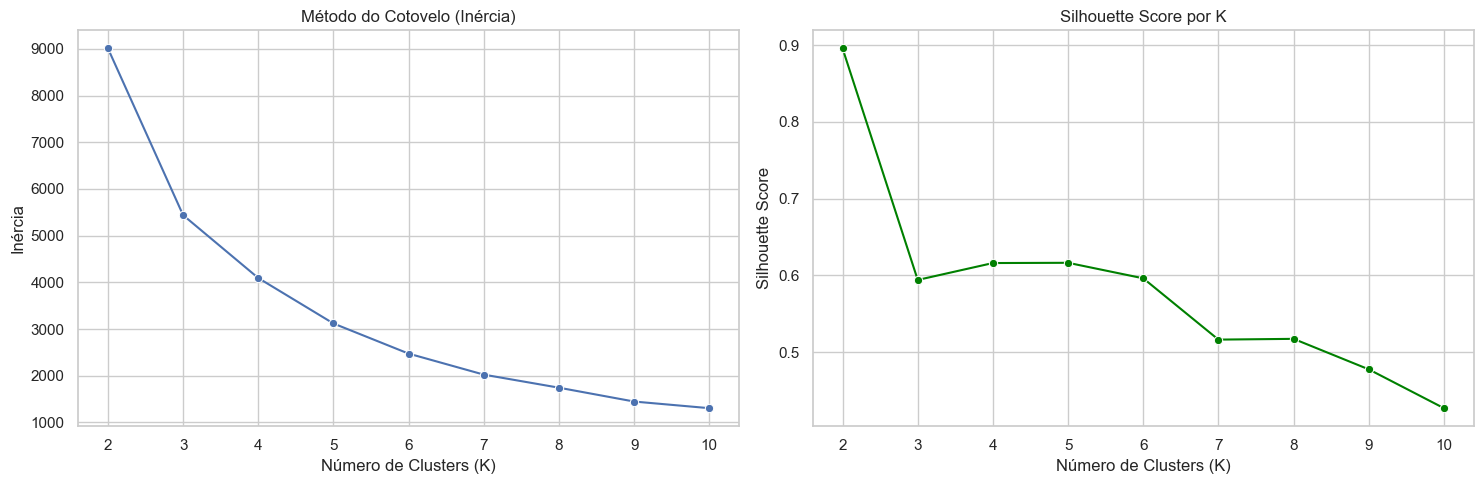

In [9]:
# 1. Importação das bibliotecas de modelagem e métricas
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Configuração visual
sns.set(style="whitegrid")

# 2. Definição do intervalo de K a ser testado
range_n_clusters = range(2, 11)  # Testar de 2 a 10 clusters

# Listas para armazenar as métricas de cada rodada
inertias = []
silhouette_scores = []

# 3. Loop de Treinamento e Avaliação
print("Iniciando avaliação de clusters...")

for k in range_n_clusters:
    # Instanciar o modelo com random_state fixo para reprodutibilidade
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Treinar o modelo nos dados padronizados
    kmeans.fit(df_rfm_scaled)
    
    # Armazenar a Inércia
    inertias.append(kmeans.inertia_)
    
    # Calcular e armazenar o Silhouette Score
    score = silhouette_score(df_rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    
    print(f"K={k} | Inércia: {kmeans.inertia_:.2f} | Silhouette: {score:.3f}")

# 4. Visualização dos Resultados (Método do Cotovelo e Silhouette)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Método do Cotovelo (Inércia)
sns.lineplot(x=range_n_clusters, y=inertias, marker='o', ax=ax[0])
ax[0].set_title('Método do Cotovelo (Inércia)')
ax[0].set_xlabel('Número de Clusters (K)')
ax[0].set_ylabel('Inércia')

# Gráfico 2: Análise de Silhueta
sns.lineplot(x=range_n_clusters, y=silhouette_scores, marker='o', color='green', ax=ax[1])
ax[1].set_title('Silhouette Score por K')
ax[1].set_xlabel('Número de Clusters (K)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# 6. Escolha do K e Treinamento do Modelo Final

Embora a análise de Silhueta tenha indicado um score máximo em $K=2$ (0.89), optou-se por utilizar **$K=4$** (Score: 0.61) para o modelo final.

**Justificativa de Negócio:**
Uma segmentação binária ($K=2$) tende a separar apenas "Compradores Médios" de "Outliers de Alto Valor", o que oferece pouca flexibilidade para estratégias de marketing distintas. Com 4 clusters, mantemos uma alta qualidade de separação (Silhouette > 0.6) ao mesmo tempo que aumentamos a granularidade para identificar perfis como clientes em risco, leais ou novos entrantes.

O gráfico de Inércia (Método do Cotovelo) também demonstra que a partir de $K=4$ os ganhos de compactação tornam-se marginais, corroborando a escolha.

In [10]:
# 1. Treinando o modelo final com K=4
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_final.fit(df_rfm_scaled)

# 2. Atribuindo os clusters aos dados originais (não escalonados)
# Importante: Usamos o df_rfm original para interpretar os valores reais (R$, Dias), 
# pois ler dados padronizados (0.5, -1.2) é difícil para humanos.
df_rfm['Cluster'] = kmeans_final.labels_

# 3. Analisando o perfil de cada Cluster (Centróides)
# Agrupamos pelo Cluster e tiramos a média de Recência, Frequência e Monetário
analysis = df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count' # Para saber quantos clientes tem em cada grupo
}).sort_values(by='Monetary', ascending=False) # Ordenar pelos que gastam mais

# Renomeando coluna de contagem
analysis = analysis.rename(columns={'Cluster': 'Num_Customers'})

print("Perfil Médio de cada Cluster:")
display(analysis.round(2))

Perfil Médio de cada Cluster:


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
2,7.38,82.54,127338.31,13
3,15.50,22.33,12709.09,204
0,43.70,3.68,1359.05,3054
1,248.08,1.55,480.62,1067


# 7. Interpretação e Visualização dos Resultados

Com base nas médias calculadas para cada grupo, foi possível identificar 4 perfis distintos de comportamento. Os clusters foram rotulados da seguinte forma para facilitar a comunicação com a área de negócios:

* **Cluster VIP (Ouro):** Alto volume de compras e ticket médio elevadíssimo. Representam a elite da base.
* **Cluster Leais (Prata):** Boa frequência e valor monetário consistente. Clientes ativos e engajados.
* **Cluster Novos/Casuais (Bronze):** A grande massa de clientes com compras esporádicas e ticket médio moderado.
* **Cluster Churn/Inativos (Risco):** Clientes que não compram há muito tempo (alta recência) e tiveram baixo engajamento prévio.

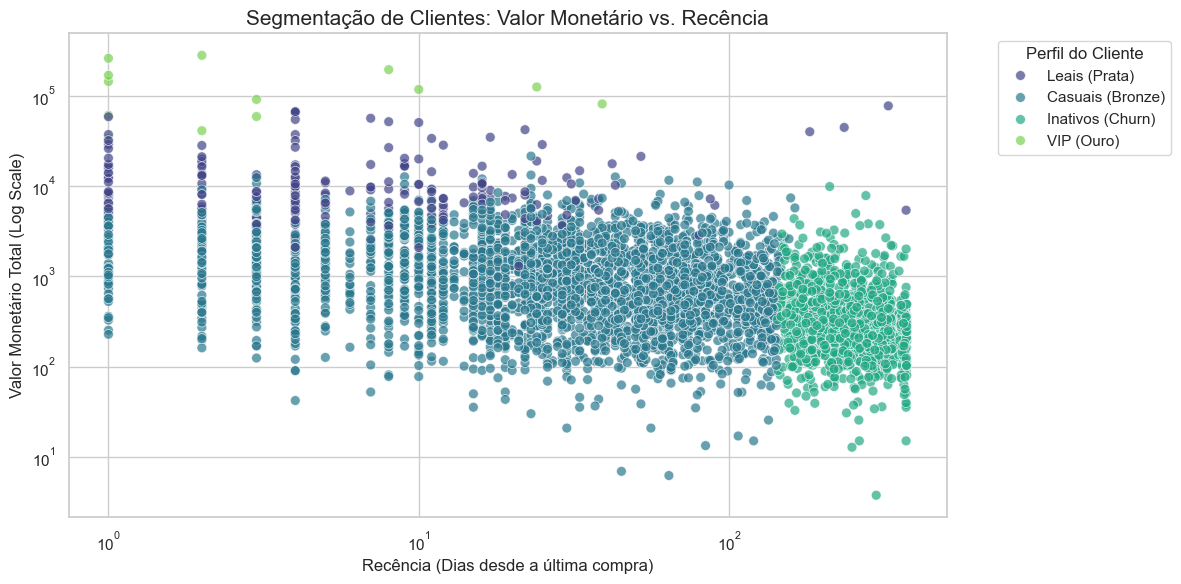

,Recency,Frequency,Monetary,Cluster,Profile
CustomerID,,,,,
12346.0,326,1,77183.60,3,Leais (Prata)
12347.0,2,7,4310.00,0,Casuais (Bronze)
12348.0,75,4,1797.24,0,Casuais (Bronze)
12349.0,19,1,1757.55,0,Casuais (Bronze)
12350.0,310,1,334.40,1,Inativos (Churn)


In [11]:
# 1. Criando um dicionário para dar nomes aos clusters (Baseado na sua tabela)
# Atenção: Verifique se os números dos clusters coincidem com a sua execução!
cluster_names = {
    2: 'VIP (Ouro)',
    3: 'Leais (Prata)',
    0: 'Casuais (Bronze)',
    1: 'Inativos (Churn)'
}

# 2. Aplicando os nomes ao DataFrame
df_rfm['Profile'] = df_rfm['Cluster'].map(cluster_names)

# 3. Visualização Gráfica (Scatter Plot)
plt.figure(figsize=(12, 6))

# Vamos usar escala logarítmica no Eixo Y (Monetário) e X (Recência)
# Motivo: A diferença entre o VIP (127k) e o Churn (400) é tão grande que 
# sem logaritmo os grupos menores ficariam "esmagados" no gráfico.
sns.scatterplot(data=df_rfm, x='Recency', y='Monetary', hue='Profile', palette='viridis', s=50, alpha=0.7)

plt.title('Segmentação de Clientes: Valor Monetário vs. Recência', fontsize=15)
plt.xlabel('Recência (Dias desde a última compra)', fontsize=12)
plt.ylabel('Valor Monetário Total (Log Scale)', fontsize=12)

# Ajuste para escala logarítmica para melhor visualização
plt.yscale('log')
plt.xscale('log')

plt.legend(title='Perfil do Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Amostra final da tabela com os nomes
display(df_rfm.head())

In [12]:
# Salvando o modelo treinado (o "cérebro" da clusterização)
joblib.dump(kmeans_final, 'kmeans_model.pkl')

print("Modelo K-Means salvo com sucesso como 'kmeans_model.pkl'")

Modelo K-Means salvo com sucesso como 'kmeans_model.pkl'


# 8. Conclusões e Estratégias de Marketing (Actionable Insights)

Após a interpretação dos clusters baseada nas métricas RFM, foram desenhadas estratégias específicas para maximizar o valor de cada segmento de clientes. A análise permitiu sair de uma abordagem de "marketing de massa" para uma comunicação personalizada.

### 📋 Resumo dos Perfis e Ações Recomendadas

| Cluster (Perfil) | Características Principais | Sugestão de Ação / Campanha |
| :--- | :--- | :--- |
| **VIP (Ouro)** | • Alto Ticket Médio (Gastam muito)<br>• Compra Recente<br>• Alta Frequência | **Campanha "Clube exclusivo":**<br>• Atendimento prioritário (Gerente de Conta).<br>• Acesso antecipado a novos produtos.<br>• Frete grátis incondicional.<br>• *Objetivo:* Retenção total e manter o status. |
| **Leais (Prata)** | • Bom Ticket Médio<br>• Frequência regular<br>• Recência baixa | **Campanha "Upsell & Cross-sell":**<br>• Recomendações de produtos complementares.<br>• Programas de fidelidade (pontos por compra).<br>• *Objetivo:* Aumentar o ticket médio para transformá-los em VIPs. |
| **Casuais (Bronze)** | • Ticket Baixo<br>• Baixa Frequência<br>• Recência média | **Campanha "Reativação Suave":**<br>• Cupons de desconto por tempo limitado.<br>• Promoções de "Leve 3 Pague 2" para aumentar volume.<br>• *Objetivo:* Aumentar a frequência de compra. |
| **Inativos (Churn)** | • Não compram há muito tempo (+200 dias)<br>• Baixo histórico de valor | **Campanha "Win-Back":**<br>• E-mail automático: "Estamos com saudades".<br>• Pesquisa de satisfação para entender a saída.<br>• *Objetivo:* Recuperar o cliente ou limpar da base de e-mail marketing para reduzir custos. |

---
**Próximos Passos (Sugestão de Evolução):**
1.  Testar as campanhas em pequenos grupos (Testes A/B).
2.  Automatizar a pipeline para rodar este modelo mensalmente e reclassificar os clientes.